# <a id='toc1_'></a>[Add constrains on identified capacity](#toc0_)

In [1]:
# Load modules
# Mark Ruihe change 
import sys  ; import pybamm; import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\\Niall_DMA\\Data Analysis Functions"))
sys.path.append(str_path_1) 

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Standard python libraries required for this to work
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.lines import Line2D
import numpy as np
from scipy import optimize

# Some modules I wrote which contain functions used for data processing/analysis
import NDK_functions_Biologic_loading as bl
import NDK_functions_Degradation_Modes as dm
import NDK_functions_Degradation_Modes_composites as dmc

# To graph the results within the Notebook
# %matplotlib notebook
import matplotlib as mpl; fs=17; 
font = {'family' : 'DejaVu Sans',
        #'weight' : 'bold',
        'size'   : fs}
mpl.rc('font', **font)
from random import seed,random

In [2]:
# Load reference 1/2 cell datasets for each electrode/component (1 for PE, 2 for NE)
PE_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/LGM50_NMC_PE_lithiation_OCV_v2.csv', 
    index_col=0)
NE_LGM50_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/LGM50_SiGr_NE_delithiation_OCV.csv', 
    index_col=0)
NE_Gr_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/Gr_NE_OCV_delithiation.csv', 
    index_col=0)
NE_Si_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/Si_NE_OCV_delithiation_NEW(pure-Si(100mV)cycle2).csv', 
    index_col=0)

In [3]:
# Load full cell datasets to be analysed (a BoL dataset and some aged cell datasets)
AgeDataPath = "D:/OneDrive - Imperial College London/Degradation Tests/"
Path_Exp   = "Expt 3 - Cathode Degradation and Li-Plating/Performance Checks/"
SavePath = "D:/OneDrive - Imperial College London/SimDataSave/DMA_Niall_Ruihe/Exp3/"
import traceback
Rig_Exp3 = {
    "A":"1","B":"1","C":"1",
    "D":"3","E":"3","F":"3",
    "G":"6","H":"6","I":"6",}
Temp_Exp3 = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40",}
def Read_Path(AgeDataPath,Path_Exp,Exp_num,Rig_Exp3,NumRPT,str_cell):
    Cell_i_1RPT = bl.combo_function_fast(
        AgeDataPath+Path_Exp+  "BoL/Slow/" +   #  "RPT1/"
        f"NDK - LG M50 deg - exp {Exp_num} - rig {Rig_Exp3[str_cell]} - {Temp_Exp3[str_cell]}degC - cell {str_cell} - BoL (slow)_01_MB_CD6.mpt"
        )
    cellData = []
    cellData.append(Cell_i_1RPT)
    for i in range(1,NumRPT+1):
        try:
            cell_RPT_i = bl.combo_function_fast(
                AgeDataPath+Path_Exp+    f"RPT{i}/" +
                f'NDK - LG M50 deg - exp {Exp_num} - rig {Rig_Exp3[str_cell]} - {Temp_Exp3[str_cell]}degC - cell {str_cell} - RPT{i}_01_MB_CB6.mpt'
                )
        except Exception as e:
            # traceback.print_exc()
            print(f"Cell {str_cell} does not have RPT-{i}")
        else:
            cellData.append(cell_RPT_i)
    return cellData
# Mark Ruihe: define some new functions here:
# 1-Define a function to generate random numbers based on given values:
def Guess_0_Random(Num_try,guess_values_0,Min_guess_0,Max_guess_0):
    Min_guess = []; Max_guess =[]
    Guess_Values =[]
    for i in range(5):
        Min_guess.append( max(guess_values_0[i]*0.98,Min_guess_0[i])  )
        Max_guess.append( min(guess_values_0[i]*1.05,Max_guess_0[i])   ) 
    seed(1) # seed random number generator
    # generate random numbers between 0-1
    for k in range(Num_try):
        guess_values_i =[];
        for i in range(5):
            value = random()
            value_i =  Min_guess[i] + (value * (Max_guess[i] - Min_guess[i]))
            guess_values_i.append(value_i)
        Guess_Values.append(guess_values_i)
    return Guess_Values
# 2-Define a function to find the 8 min fits
# print(Err_1Cell1RPT_Alltries*1e3)
def Find_min(Err_1Cell1RPT_Alltries,Min_num):
    import copy
    Err_temp = copy.deepcopy(Err_1Cell1RPT_Alltries.tolist())
    min_number = []
    Min_index = []
    for _ in range(Min_num):
        number = min(Err_temp)
        i_temp = Err_temp.index(number)
        Err_temp[i_temp] = 1e6
        min_number.append(number)
        Min_index.append(i_temp)
        # print(number*1e3,i_temp)
    Err_temp = []
    return Min_index
# 3- Define a function to wrap OCV and plot 8 best fits,  but not yet decide on which one
def Wrap_OCV_Fit(Input_pack):  
    
    # Unpack input parameters:
    [Cell_i_Dis_1RPT, str_cell, RPT_num, Num_try,
        guess_values_0, Min_guess_0, Max_guess_0,
        NE_Gr_OCV, NE_Si_OCV, PE_OCV,Path, Save,fs,lw,ms,dpi] = Input_pack

    

    Cell_i_Dis_1RPT = Cell_i_Dis_1RPT[
        Cell_i_Dis_1RPT[
        'Current (mA)']<0].loc[
        :, ['Charge (mA.h)', 'Voltage (V)']]
    Cell_i_Dis_1RPT.reset_index(inplace=True, drop=True)
    Cell_i_Dis_1RPT['SOC (%)'] =(
        1 - 
        Cell_i_Dis_1RPT['Charge (mA.h)']
        /Cell_i_Dis_1RPT['Charge (mA.h)'].max()   )

    z_1Cell1RPT_Alltries = [];   Err_1Cell1RPT_Alltries=[]; 
    Fit_1Cell1RPT_Alltries = []; Cap_1Cell1RPT_Alltries=[]; 
    Guess_Values = Guess_0_Random(Num_try,guess_values_0,Min_guess_0,Max_guess_0)
    for guess_values in Guess_Values:
        z_out, _, Cap_out = dmc.stoich_OCV_fit_multi_comp(
            NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT,
            z_guess=guess_values)
        Fit_1Cell1RPT, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(
            NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT['SOC (%)'], 
            *z_out)
        fitted_Gr_fract = z_out[4].round(4)
        fitted_Si_fract = 1-fitted_Gr_fract
        err_BoL = dmc.DM_error_check(
            NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT, 
            z_out)
        # print(f"RMSE for {guess_values} is {(err_BoL*1e3).round(2)} mV")
        # Append
        z_1Cell1RPT_Alltries.append(z_out);          Err_1Cell1RPT_Alltries.append(err_BoL) 
        Fit_1Cell1RPT_Alltries.append(Fit_1Cell1RPT);Cap_1Cell1RPT_Alltries.append(Cap_out)

    Err_1Cell1RPT_Alltries = np.array(Err_1Cell1RPT_Alltries)    
    Min_index = Find_min(Err_1Cell1RPT_Alltries,8)
    
    # History: for 20 rounds of optimization, 64s is needed. 
    import matplotlib as mpl; import copy; 
    font = {'family' : 'DejaVu Sans','size': fs}
    mpl.rc('font', **font)
    Index_Plot = {
        "0":[0,1],"1":[0,2],"2":[1,0],"3":[1,1],
        "4":[1,2],"5":[2,0],"6":[2,1],"7":[2,2] }

    # Start a plot
    Fig_DMA_1cell1RPT, ax = plt.subplots(3,3,  figsize=(16,12))
    Err_1Cell1RPT_Alltries_temp = copy.deepcopy(Err_1Cell1RPT_Alltries)
    Err_1Cell1RPT_Alltries_temp = abs( np.sort(-Err_1Cell1RPT_Alltries_temp)); 
    Temp_List = np.arange(1,len(Err_1Cell1RPT_Alltries_temp)+1)
    ax[0,0].plot(Temp_List,  Err_1Cell1RPT_Alltries_temp*1e3,  
        color='grey',linewidth=lw,  linestyle='-',marker = 'o',markersize = ms)
    ax[0,0].plot(Temp_List[-8:] ,  Err_1Cell1RPT_Alltries_temp[-8:]*1e3,  
        color='b',linewidth=lw,  linestyle='none',marker = 'o',markersize = ms+2)
    # ax[0,0].set_ylim([3 , 15])
    ax[0,0].set_ylabel('RMSE (mV)')
    ax[0,0].set_xlabel('Try number (sort)')
    # plot things:
    for min_index,i in zip(Min_index,range(len(Min_index))):
        SOC_OCV_Temp = Fit_1Cell1RPT_Alltries[min_index].to_numpy()
        SOC_OCV_Exp  = Cell_i_Dis_1RPT.to_numpy()
        m,n = Index_Plot[str(i)]
        ax[m,n].plot(SOC_OCV_Exp[:,2]*100,SOC_OCV_Exp[:,1],linewidth=lw, ls='-',color='k',label='Exp', ) 
        ax[m,n].plot(SOC_OCV_Temp[:,0]*100,SOC_OCV_Temp[:,1],linewidth=lw, ls='--',color='b',label='Fit', ) 
        ax[m,n].set_xlabel('SOC %')
        ax[m,n].invert_xaxis()
        ax[m,n].set_ylabel('Voltage (V)')
        ax[m,n].text(75,2.7,
            f'Try Num: {min_index}\nRMSE: {format(Err_1Cell1RPT_Alltries[min_index]*1e3,".2f")} mV',
            horizontalalignment='left',
            verticalalignment='bottom', fontsize=fs)
    ax[0,1].legend(frameon=False,)

    Fig_DMA_1cell1RPT.suptitle(
        f'Fit result of Cell {str_cell}, RPT-{RPT_num}', 
        fontsize=fs+4)
    Fig_DMA_1cell1RPT.tight_layout()
    if Save == True:
        Fig_DMA_1cell1RPT.savefig(
            Path + f"Cell_{str_cell}_RPT_{RPT_num}_8bestFits.png", dpi=dpi)
    
    Out_1Cell1RPT = [
        z_1Cell1RPT_Alltries, Err_1Cell1RPT_Alltries, Fit_1Cell1RPT_Alltries, Cell_i_Dis_1RPT, 
        Cap_1Cell1RPT_Alltries,Min_index ]

    return Out_1Cell1RPT


Cell A does not have RPT-11
Cell A does not have RPT-12


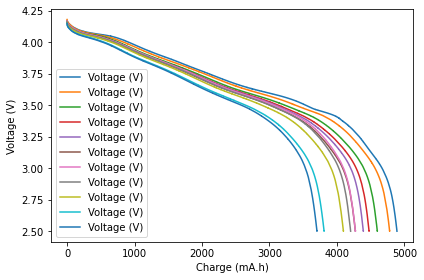

In [4]:
cellData_A = Read_Path(AgeDataPath,Path_Exp,3,Rig_Exp3,12,"A")
# Plot of the discharge voltage curves for the 3 datasets being analysed
fig_V_curves, ax = plt.subplots()
for cell in cellData_A:
    data_to_plot = cell[cell['Current (mA)'] < 0]
    data_to_plot.plot('Charge (mA.h)', 'Voltage (V)', ax=ax, )
ax.set_ylabel('Voltage (V)')
fig_V_curves.tight_layout()

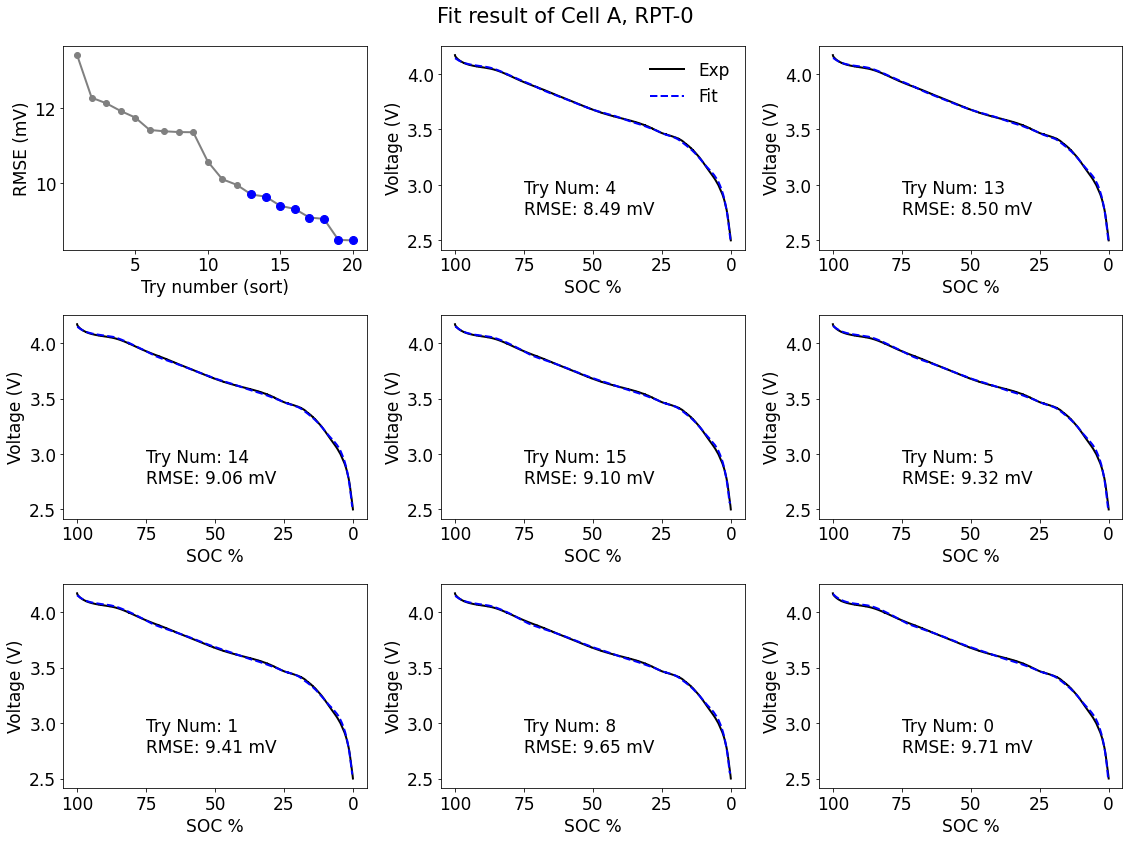

In [5]:
# Do the actual OCV fit!

# Global settings: initial guess range - should be the same in at least one Exp set. 
#   PE_lo	NE_lo	PE_hi	NE_hi	Gr_frac
Min_guess_0 = [0.01, 0.001, 0.90, 0.80 , 0.70 ]; 
Max_guess_0 = [0.23, 0.05, 0.99, 0.95, 0.87]; 
str_cell = 'A'; Num_try = 20;  
dpi = 300; fs=17; lw=2; ms=6; Save = True; 
guess_values_0 = [0.1, 0.002, 0.95, 0.85, 0.84] # The guess value for BoL
# Results for One cell all RPTs:
z_1CellAllRPTs=[];    Err_1CellAllRPTs=[];     Fit_1CellAllRPTs=[]; Exp_1CellAllRPTs=[];
Cap_1CellAllRPTs=[];  Index_1CellAllRPTs = []; Guess_values_0_1CellAllRPTs =[guess_values_0,]
# start from BoL:
RPT_num =  0
Cell_i_Dis_1RPT = eval("cellData_{}".format(str_cell))[RPT_num].copy() # This is where choose the cell and RPT
 # input values: 
# Fit!!!
[
    z_1Cell1RPT_Alltries, Err_1Cell1RPT_Alltries, Fit_1Cell1RPT_Alltries, Cell_i_Dis_1RPT, 
    Cap_1Cell1RPT_Alltries,Min_index ] =  Wrap_OCV_Fit([
        Cell_i_Dis_1RPT, str_cell, RPT_num, Num_try,
        Guess_values_0_1CellAllRPTs[-1], Min_guess_0, Max_guess_0,
        NE_Gr_OCV, NE_Si_OCV, PE_OCV,SavePath, Save,fs,lw,ms,dpi ])
# Make decision now: after visual inspection:
Index_1CellAllRPTs.append(Min_index[0] )  # start from always pick the lowest RMSE ones
# in the future, maybe consider to compare Cap_1CellAllRPTs
# Append others:
Exp_1CellAllRPTs.append(Cell_i_Dis_1RPT)
Guess_values_0_1CellAllRPTs.append(z_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])
z_1CellAllRPTs  .append(z_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])
Err_1CellAllRPTs.append(Err_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])
Fit_1CellAllRPTs.append(Fit_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])
Cap_1CellAllRPTs.append(Cap_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])

In [16]:
Cap_NESi_estimated = Cap_1CellAllRPTs[-1][4]
Cap_NEto_estimated = Cap_1CellAllRPTs[-1][2]
print(Cap_NESi_estimated, Cap_NEto_estimated)
#
RPT_num = 1
Cell_i_Dis_1RPT = eval("cellData_{}".format(str_cell))[RPT_num].copy() # This is where choose the cell and RPT
Path = SavePath
Input_pack = [Cell_i_Dis_1RPT, str_cell, RPT_num, Num_try,
        guess_values_0, Min_guess_0, Max_guess_0,
        Cap_NESi_estimated, Cap_NEto_estimated,
        NE_Gr_OCV, NE_Si_OCV, PE_OCV,Path, Save,fs,lw,ms,dpi,
        ]
Cell_i_Dis_1RPT = Cell_i_Dis_1RPT[
        Cell_i_Dis_1RPT[
        'Current (mA)']<0].loc[:, ['Charge (mA.h)', 'Voltage (V)']]
Cell_i_Dis_1RPT.reset_index(inplace=True, drop=True)
Cell_i_Dis_1RPT['SOC (%)'] =(
        1 - 
        Cell_i_Dis_1RPT['Charge (mA.h)']
        /Cell_i_Dis_1RPT['Charge (mA.h)'].max()   )

z_1Cell1RPT_Alltries = [];   Err_1Cell1RPT_Alltries=[]; 
Fit_1Cell1RPT_Alltries = []; Cap_1Cell1RPT_Alltries=[]; 
Cap_NESi_1Cell1RPT_Alltries=[];  Cap_NEto_1Cell1RPT_Alltries=[];
Guess_Values = Guess_0_Random(Num_try,guess_values_0,Min_guess_0,Max_guess_0)
for guess_values in Guess_Values:
        z_out, _, Cap_out = dmc.stoich_OCV_fit_multi_comp(
                NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT,
                z_guess=guess_values)
        Cap_NESi_1Cell1RPT_Alltries.append(Cap_out[4])
        Cap_NEto_1Cell1RPT_Alltries.append(Cap_out[2])
        Fit_1Cell1RPT, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(
                NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT['SOC (%)'], 
                *z_out)
        fitted_Gr_fract = z_out[4].round(4)
        fitted_Si_fract = 1-fitted_Gr_fract
        err_BoL = dmc.DM_error_check(
                NE_Gr_OCV, NE_Si_OCV, PE_OCV, Cell_i_Dis_1RPT, 
                z_out)
        # print(f"RMSE for {guess_values} is {(err_BoL*1e3).round(2)} mV")
        # Append
        z_1Cell1RPT_Alltries.append(z_out);          Err_1Cell1RPT_Alltries.append(err_BoL) 
        Fit_1Cell1RPT_Alltries.append(Fit_1Cell1RPT);Cap_1Cell1RPT_Alltries.append(Cap_out)


803.2806524784671 5288.238240235837


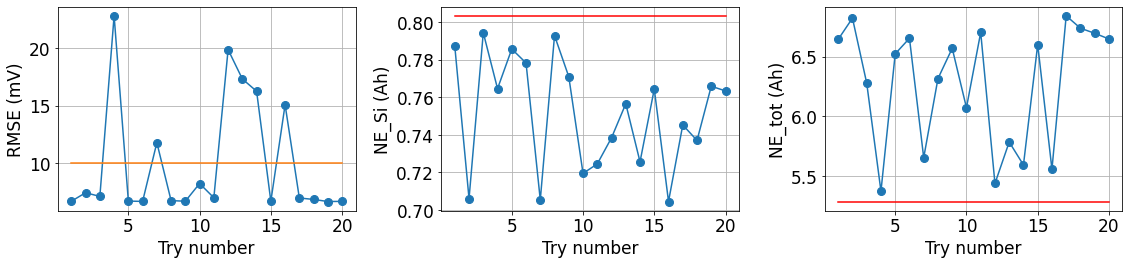

In [35]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(np.arange(1,Num_try+1),np.array(Err_1Cell1RPT_Alltries)*1e3 ,linestyle='-',marker = 'o',markersize = ms+2)
ax[0].plot(np.arange(1,Num_try+1),np.full([Num_try,1],10) ,linestyle='-',)
ax[0].set_ylabel('RMSE (mV)')
ax[1].plot(np.arange(1,Num_try+1),np.array(Cap_NESi_1Cell1RPT_Alltries)/1e3,linestyle='-',marker = 'o',markersize = ms+2 )
ax[1].plot(
    np.arange(1,Num_try+1),
    np.full([Num_try,1],Cap_NESi_estimated/1e3),
    color='r',linestyle='-' )
ax[1].set_ylabel('NE_Si (Ah)')
ax[2].plot(np.arange(1,Num_try+1),np.array(Cap_NEto_1Cell1RPT_Alltries)/1e3,linestyle='-',marker = 'o',markersize = ms+2 )
ax[2].plot(
    np.arange(1,Num_try+1),
    np.full([Num_try,1],Cap_NEto_estimated/1e3) ,
    color='r',linestyle='-' )
ax[2].set_ylabel('NE_tot (Ah)')

for i in range(3):
    ax[i].set_xlabel('Try number')
    ax[i].grid()

fig.tight_layout()

In [ ]:
for RPT_num in np.arange(1,11):
    Cell_i_Dis_1RPT = eval("cellData_{}".format(str_cell))[RPT_num].copy() # This is where choose the cell and RPT
    # input values: 
    # Fit!!!
    [
        z_1Cell1RPT_Alltries, Err_1Cell1RPT_Alltries, Fit_1Cell1RPT_Alltries,Cell_i_Dis_1RPT, 
        Cap_1Cell1RPT_Alltries,Min_index ] =  Wrap_OCV_Fit([
            Cell_i_Dis_1RPT, str_cell, RPT_num, Num_try,
            Guess_values_0_1CellAllRPTs[-1], Min_guess_0, Max_guess_0,
            NE_Gr_OCV, NE_Si_OCV, PE_OCV,SavePath, Save,fs,lw,ms,dpi] )
    # Make decision now: after visual inspection:
    Index_1CellAllRPTs.append(Min_index[0] )  # start from always pick the lowest RMSE ones
    # in the future, maybe consider to compare Cap_1CellAllRPTs
    # Append others:
    Exp_1CellAllRPTs.append(Cell_i_Dis_1RPT)
    Guess_values_0_1CellAllRPTs.append(z_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])
    z_1CellAllRPTs  .append(z_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])  # identified electrode sto / SOC  
    Err_1CellAllRPTs.append(Err_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])# RMSE
    Fit_1CellAllRPTs.append(Fit_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])# Fitted voltage 
    Cap_1CellAllRPTs.append(Cap_1Cell1RPT_Alltries[Index_1CellAllRPTs[-1]])# identified electrode cap

# Post-processing

In [ ]:
# Now follow Niall's operation: make list into pandas DataFrame
z_1CellAllRPTs_df = pd.DataFrame(data=z_1CellAllRPTs, columns=['PE_lo', 'NE_lo', 'PE_hi', 'NE_hi', 'Gr_frac'])
Cap_1CellAllRPTs_df = pd.DataFrame(
    data=Cap_1CellAllRPTs, 
    columns=[
    'Cell Cap', 'PE Cap', 'NE(tot) Cap', 
    'NE(Gr) Cap', 'NE(Si) Cap', 'Offset'])
Err_1CellAllRPTs_df = pd.DataFrame(data={'RMSE (V)':Err_1CellAllRPTs})   # RMSE for one cell, all RPTs
SoH = Cap_1CellAllRPTs_df['Cell Cap']/Cap_1CellAllRPTs_df['Cell Cap'][0]
LAM_pe = 1 - (Cap_1CellAllRPTs_df['PE Cap']/Cap_1CellAllRPTs_df['PE Cap'][0])
LAM_ne_tot = 1 - (Cap_1CellAllRPTs_df['NE(tot) Cap']/Cap_1CellAllRPTs_df['NE(tot) Cap'][0])
LAM_ne_Gr = 1 - (Cap_1CellAllRPTs_df['NE(Gr) Cap']/Cap_1CellAllRPTs_df['NE(Gr) Cap'][0])
LAM_ne_Si = 1 - (Cap_1CellAllRPTs_df['NE(Si) Cap']/Cap_1CellAllRPTs_df['NE(Si) Cap'][0])
LLI = ((
        Cap_1CellAllRPTs_df['PE Cap'][0] - Cap_1CellAllRPTs_df['PE Cap'] - 
        (Cap_1CellAllRPTs_df['Offset'][0]-Cap_1CellAllRPTs_df['Offset'])       )
    /Cap_1CellAllRPTs_df['Cell Cap'][0] )
# Compile the DM parameters into a dataframe
DM_df = pd.DataFrame(
    data={
    'SoH':SoH, 'LAM PE':LAM_pe, 'LAM NE_tot':LAM_ne_tot, 
    'LAM NE_Gr':LAM_ne_Gr, 'LAM NE_Si':LAM_ne_Si, 'LLI':LLI})

In [ ]:
# One figure for one RPT of one cell; therefore 9 cells; each cell has 13 RPT max; 
# total figure will be: 13*9=117 
# in each figure: sub-plot-1 for voltage fit for the best; 
#                 sub-plot-2 Dataset-number-RMSE
# another 3 plots same as Niall, but with one more plot for all voltage (best fit)
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
fig_DMA_output, ax = plt.subplots(2,2, figsize=(11,8))
for Fit_1CellAll1RPT,Cell_i_Dis_1RPT in zip(Fit_1CellAllRPTs,Exp_1CellAllRPTs):
    SOC_OCV_Temp = Fit_1CellAll1RPT.to_numpy()
    SOC_OCV_Exp  = Cell_i_Dis_1RPT.to_numpy()
    T_plot_scale = max(Cell_i_Dis_1RPT["Charge (mA.h)"])/500
    ax[0,0].plot(T_plot_scale-SOC_OCV_Exp[:,2] *T_plot_scale,SOC_OCV_Exp [:,1],linewidth=lw*0.5, ls='-', color='k',label='Exp', ) 
    ax[0,0].plot(T_plot_scale-SOC_OCV_Temp[:,0]*T_plot_scale,SOC_OCV_Temp[:,1],linewidth=lw*0.5, ls='--',color='b',label='Fit', ) 
ax[0,0].set_xlabel('Time (h)')
ax[0,0].set_ylabel('Voltage (V)')
# ax[0,0].invert_xaxis()

DM_df.plot(ax=ax[1,1], marker='o')
Cap_1CellAllRPTs_df_Ah = Cap_1CellAllRPTs_df /1e3  # temperry change to Ah
Cap_1CellAllRPTs_df_Ah.plot(ax=ax[1,0], marker='o')
Err_temp = Err_1CellAllRPTs_df.to_numpy()
ax[0,1].plot(np.arange(0,len(Err_temp)), Err_temp*1e3, linewidth=lw, ls='-',color='b',marker='o')

ax[1,1].set_ylabel('DM Fraction'); 
ax[1,1].yaxis.set_label_coords(-0.15,0.50) # need to adjust to have the best show 
ax[1,0].set_ylabel('Capacity (Ah)')
ax[0,1].set_ylabel('RMSE (mV)')
ax[0,1].set_xlabel('RPT number')
ax[1,0].set_xlabel('RPT number')
ax[1,1].set_xlabel('RPT number')
ax[1,0].legend(prop={'family':'DejaVu Sans','size':fs-3}, 
    loc='lower center', bbox_to_anchor=(0.5,0.15),
    ncol=2,frameon=True,markerscale=1,borderpad=0.2,handlelength=1.5,columnspacing=1)
ax[1,1].legend(prop={'family':'DejaVu Sans','size':fs-3},
    loc='lower center', bbox_to_anchor=(0.5,0.4),
    ncol=2,frameon=True,markerscale=1,borderpad=0.2,handlelength=1.5,columnspacing=1) # loc='best',

fig_DMA_output.tight_layout()
#if Save == True:
fig_DMA_output.savefig(
    SavePath + f"Fig. 1 Cell_{str_cell}_DMA_Summary.png", dpi=dpi)

In [ ]:
# finally, save fig and data:
df_temp  = DM_df.join(Cap_1CellAllRPTs_df)
df_temp  = df_temp.join(z_1CellAllRPTs_df)
df_temp  = df_temp.join(Err_1CellAllRPTs_df)
df_temp.head()
df_temp.to_csv(SavePath + f"Cell_{str_cell}_DMA_Summary.csv")